# Find solvation shells

Ingredients:
- trajectory
- clusters labels

Workflow:
- init analysis by getting the number and name of molecules
- for each frame analyze each the ith-cluster atoms getting their env

In [13]:
import numpy as np
import time
import os, sys
from ase.io import read, write
from tqdm import tqdm
import anaAtoms as aA
from ase import neighborlist
from collections import Counter
import ase
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import seaborn as sns
from scipy.interpolate import interp1d

In [14]:
sys.path.append('../')

In [15]:
from src import myTools, plotTools

## Load Traj

In [16]:
trajname = './0.data/traj/traj_2.1_0-1000.xyz'

In [17]:
ase_traj = read(trajname, index='0:1000:5')

In [18]:
# --- embedded data
Xemb = np.load('./2.dimreduction/dimred_data/umapSOAPdist_rcut4.5_n_Z1_Z3_Nframe1000every5.npy')
Xpca = np.load('./2.dimreduction/dimred_data/lpca_rcut4.5_n_Z1_Z3_Nframe1000every5.npy')

In [19]:
# -- cluster labels
labels = np.loadtxt('./3.clustering/hdbscan_umapSOAPdist_soapRcut45_finer.labels').astype(int)

## Init post process analysis

- get the Atoms of inerest "real" index inside the simulation box
- get the number of molecules of the simulation box

**!!!** PBC when counting the first neighbors diocane

In [20]:
rcut_correction = {'H':1,'C':1,'O':1,'Li':0.1,'P':1,'F':1}

In [21]:
molecular_species = ['EC', 'EMC', 'Li', 'PF6']

In [22]:
# extraction of the CM position for each "molecule"
moltraj = aA.extract_molecs(ase_traj[:1], 
                            fct=rcut_correction)

Extracting mol CM: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


In [23]:
rcut = 4.5

In [24]:
menvs = aA.mol_envs(moltraj, 
                    molecular_species, 
                    Rcut=rcut, 
                    returnEnvs=True)

Finding environments: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


In [25]:
# get the "in-frame" idxs of the selected molecule
CAT = 'Li'
ref_at = [idx for idx,symb in 
          enumerate(moltraj[0].arrays['molSym']) 
          if symb == CAT]

In [15]:
moltraj[0].arrays['molEnv'][ref_at][:,1]

array([2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 3, 1, 1, 3, 2, 3, 1, 4, 3, 2,
       1, 4, 5, 2, 1, 3, 0, 1, 1, 0, 3, 3, 3, 3, 5, 3, 3, 2, 3, 3, 1, 4,
       0, 5, 5, 1, 2, 3, 4, 2, 1, 3, 4, 1, 4, 3, 3, 1, 2, 4, 3, 2, 1, 5,
       2, 2, 2, 4, 1, 1, 2, 3, 1, 2, 2, 4, 1, 1, 5, 4, 2, 1, 3, 1, 2, 3,
       3, 3, 2, 1, 3, 3, 2, 3, 1, 4, 2, 1, 3, 0, 4, 3, 1, 3, 2, 3, 0, 1,
       0, 1, 1, 4])

In [16]:
# extract the number of average EC and EMC for every CAT species
species_count_dict = dict()

for i,atspe in enumerate(molecular_species):
    species_count_dict[atspe] = list()
    for ts in tqdm(moltraj, desc=f'Unwrapping {atspe}'):
        species_count_dict[atspe] += list(ts.arrays['molEnv'][ref_at][:,i])
    
    np.savetxt(f"{atspe}_counts_in{rcut}.dat", species_count_dict[atspe])

Unwrapping PF6: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 24626.74it/s]


### Plots

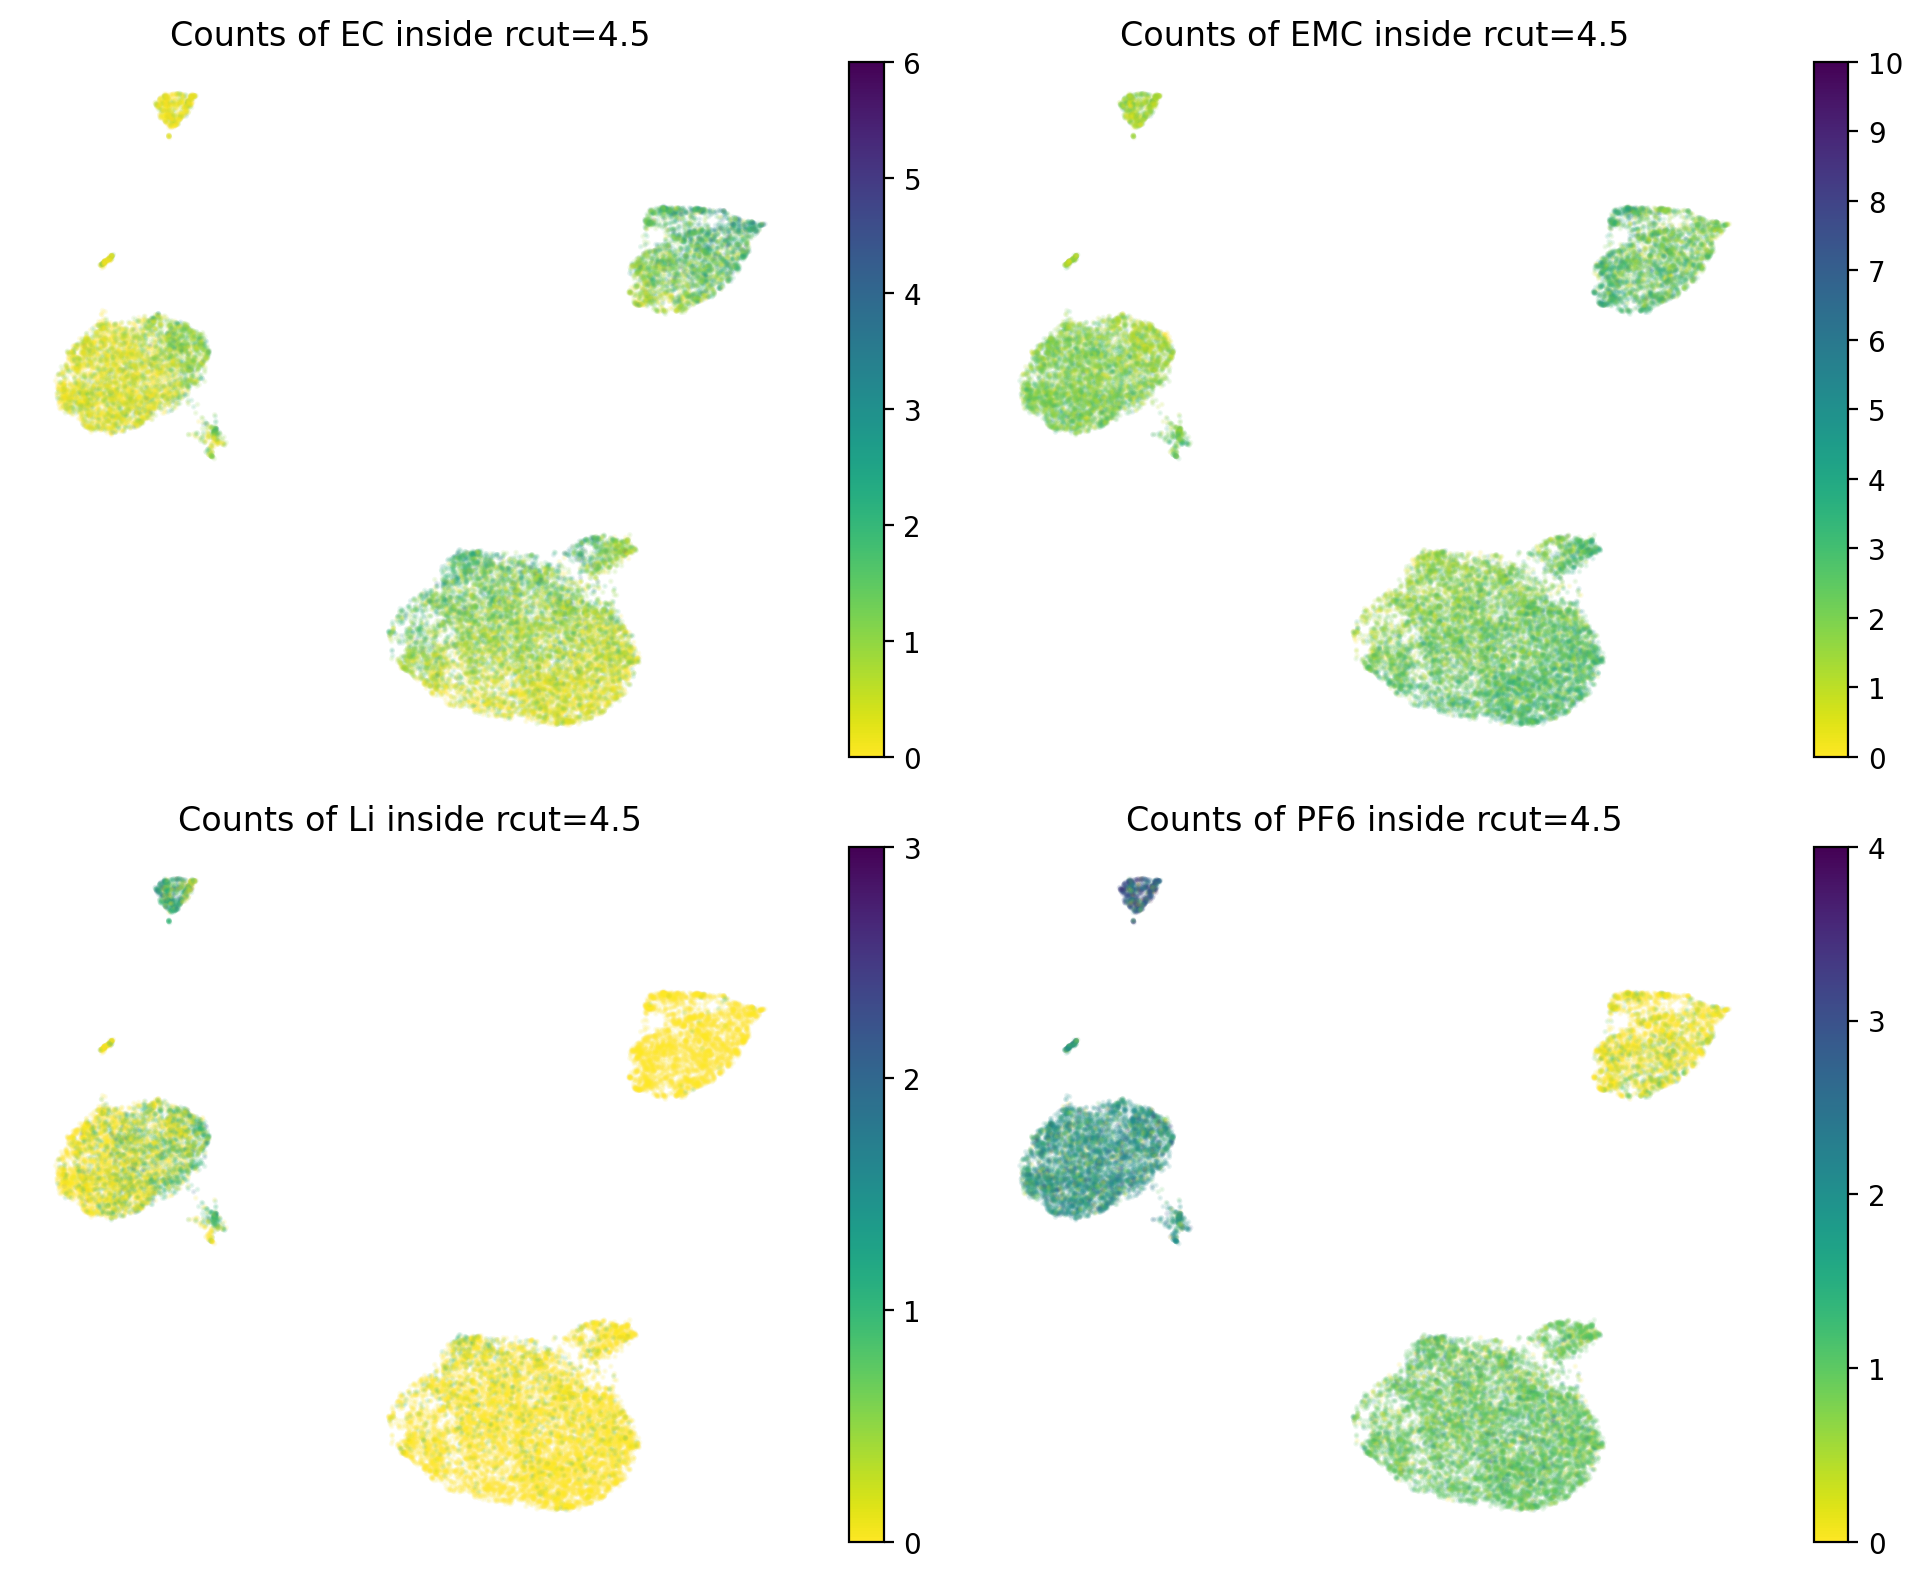

In [17]:
fig, ax = plotTools.get_axes(len(species_count_dict),2)
    
for i,(elespec,counts) in enumerate(species_count_dict.items()):
    ax[i].scatter(*Xemb.T, label=f'{elespec}', 
                  c=counts, cmap='viridis_r', s=1, alpha=.1)
    ax[i].set_title(f"Counts of {elespec} inside rcut={rcut}")
    cbarmap = plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis_r, 
                                    norm=plt.Normalize(0, np.max(counts)))
    # cbar = plt.colorbar(cbarmap, ax=ax[i])
    plt.colorbar(cbarmap, ticks=np.arange(0,np.max(counts)+1,1), ax=ax[i])
    plotTools.remove_frame(ax[i])
    
fig.tight_layout()
fig.savefig('species_counts_rcut4-5_0')

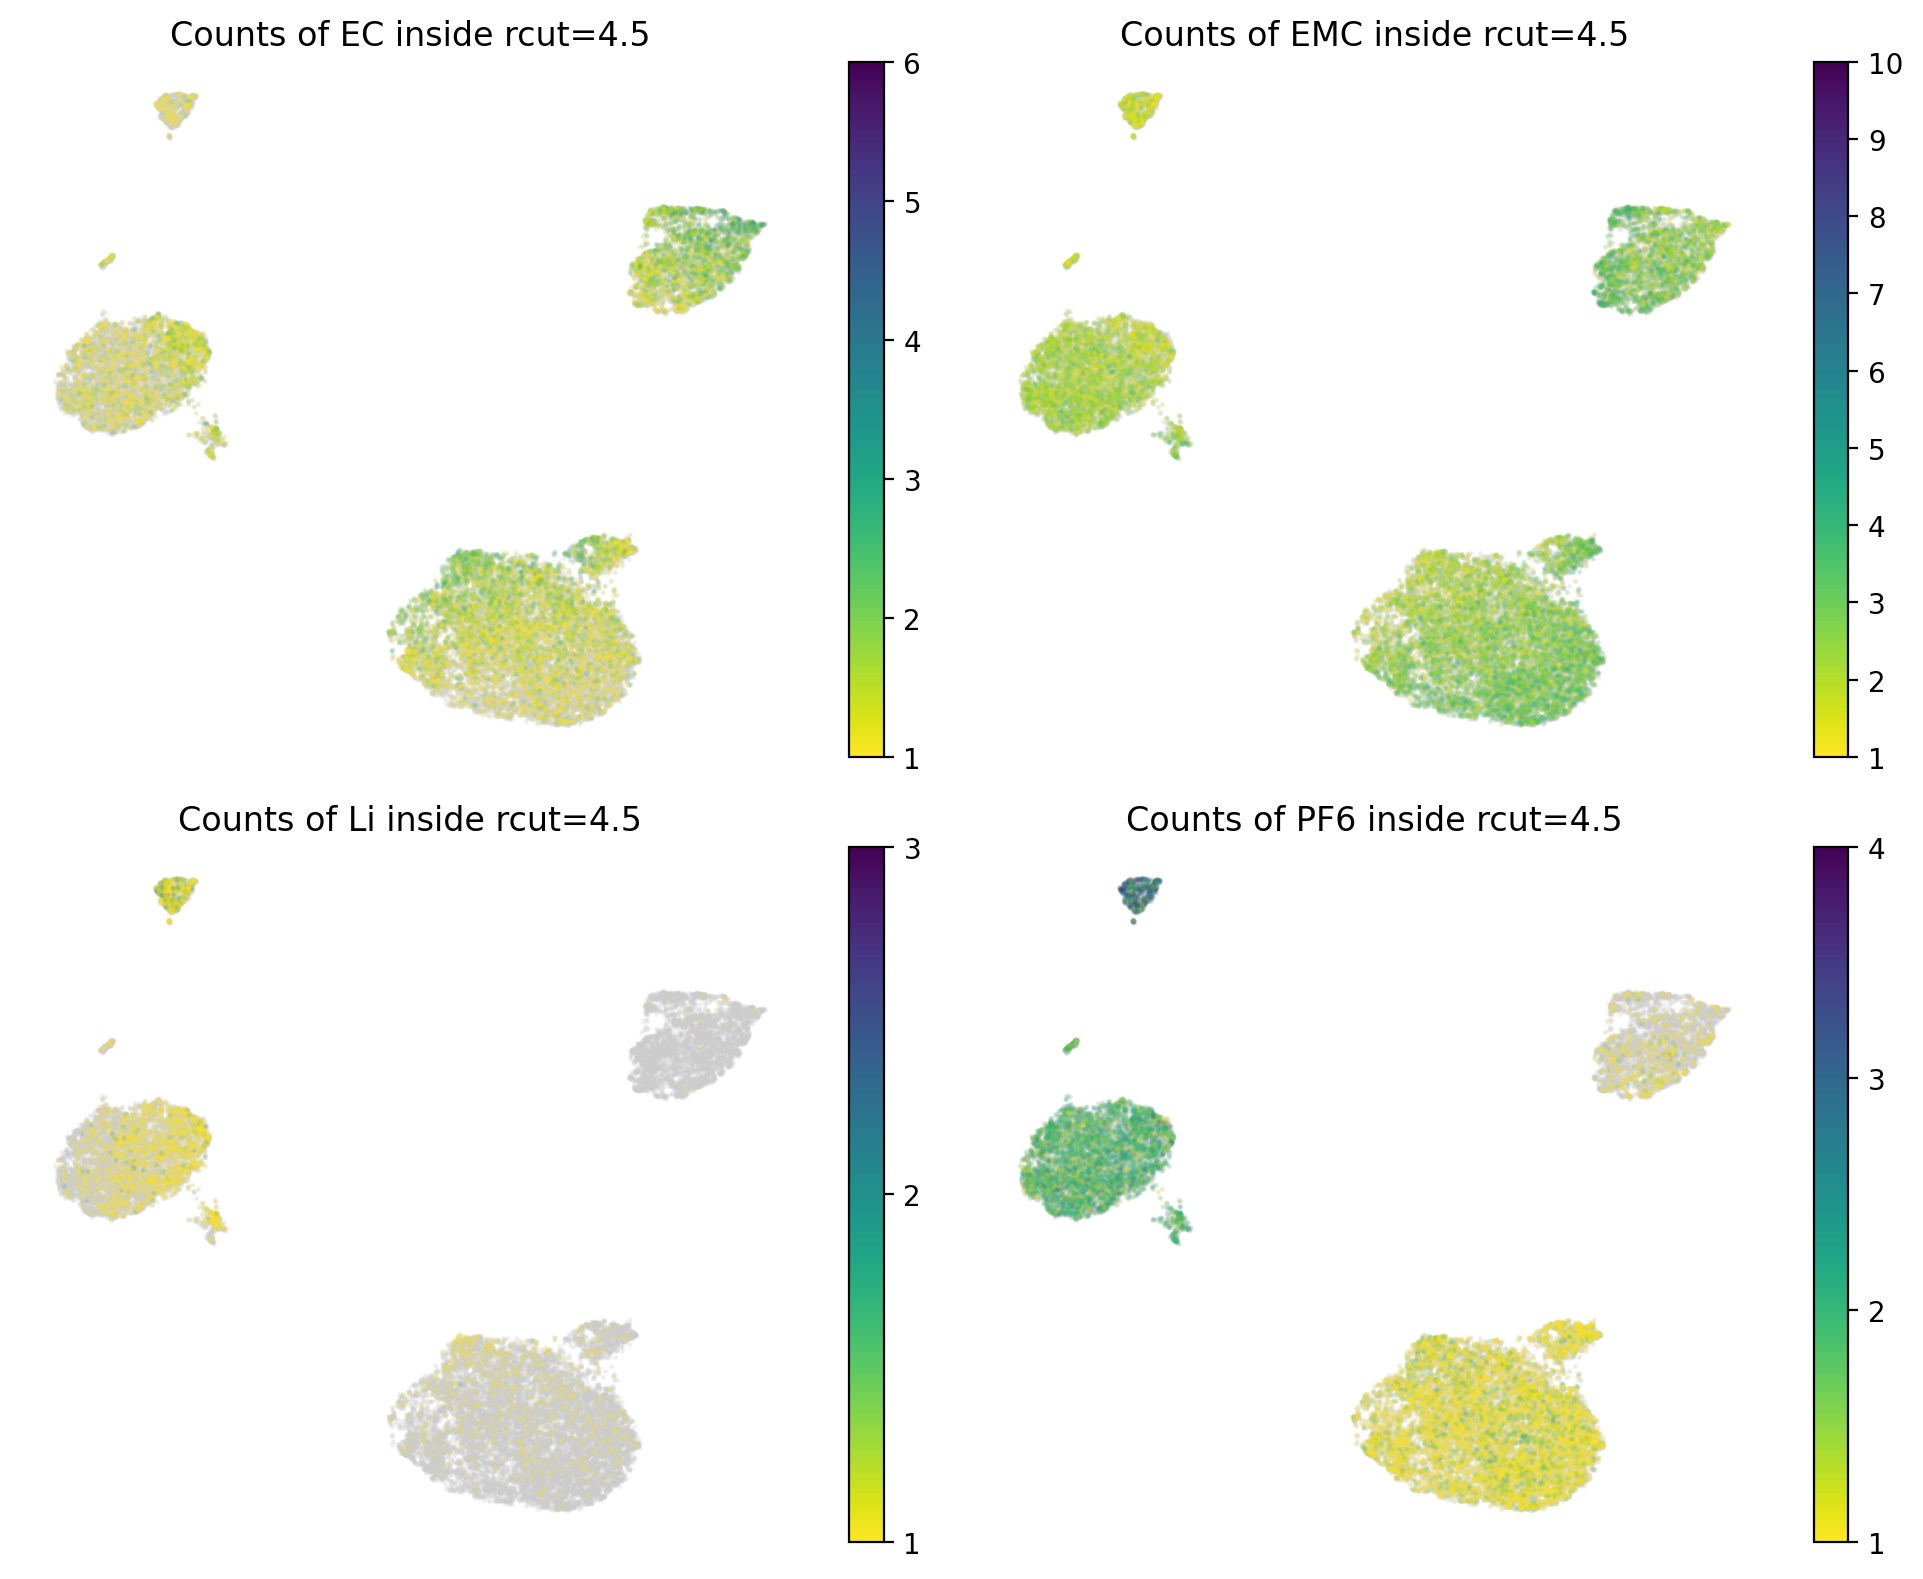

In [18]:
fig, ax = plotTools.get_axes(len(species_count_dict),2)
    
for i,(elespec,counts) in enumerate(species_count_dict.items()):
    
    mask = [i for i,idx in enumerate(counts) if idx != 0]
    maskcolors = [idx for i,idx in enumerate(counts) if idx != 0]
    
    ax[i].scatter(*Xemb.T, label=f'{elespec}', 
                  c='0.8', s=1, alpha=.2)
    ax[i].scatter(Xemb[mask,0], Xemb[mask,1], 
                  label=f'{elespec}', 
                  c=maskcolors, cmap='viridis_r', s=1, alpha=.1)

    ax[i].set_title(f"Counts of {elespec} inside rcut={rcut}")
    cbarmap = plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis_r, 
                                    norm=plt.Normalize(1, np.max(counts)))
    # cbar = plt.colorbar(cbarmap, ax=ax[i])
    plt.colorbar(cbarmap, ticks=np.arange(1,np.max(counts)+1,1), ax=ax[i])
    plotTools.remove_frame(ax[i])
    
fig.tight_layout()
fig.savefig('species_counts_rcut4-5')

In [20]:
for moleculeID in molecular_species:

    fig, ax = plotTools.get_axes(len(np.unique(labels)), 3)

    for i,clusterID in enumerate(np.unique(labels)):

        clusterMask = [cl == clusterID for cl in labels]

        clusterColor = [count_ for n,(lab_, count_) 
                        in enumerate(zip(labels, species_count_dict[moleculeID])) 
                        if lab_ == clusterID]

        ax[i].scatter(Xemb[clusterMask,0], Xemb[clusterMask,1], 
                      # s=(np.array(clusterColor).astype(float)*10)+1, 
                      s=10,
                      c=clusterColor, cmap='viridis_r', alpha=0.5)
        plotTools.remove_frame(ax[i])
        ax[i].set_title(f'{clusterID}')
        
        # inset
        axins = inset_axes(ax[i], width="25%", height="20%", 
                           loc=3, borderpad=1)
        sns.histplot(clusterColor, stat='percent', 
                     binwidth=1,
                     discrete=True,
                     kde=False,
                     line_kws=dict(lw=2),
                     ax=axins)
        axins.set_xlabel("counts")
        axins.set_xticks(np.arange(0,np.max(clusterColor)+1,1))
        # axins.set_ylim((0,30))
        
        # fig.tight_layout()
        fig.savefig(f'{moleculeID}_clusterwise_pov_rcut4-5')
        plt.close()
        
        # break

### Count species and distances

In [26]:
def count_species(occurrence, ref_species):
    counts = np.zeros(len(ref_species)).astype(int)
    for z,ref in enumerate(ref_species):
        counts[z] = np.sum([1 for occ in occurrence if occ == ref])
    return counts


def sorter_species(dists, molid, idx):
    sorter = np.argsort(dists)
    sort_molid = [molid[sort] for sort in sorter]
    sort_dists = [dists[sort] for sort in sorter]
    sort_idxs = [idx[sort] for sort in sorter]
    return sort_dists, sort_molid, sort_idxs


def center_frame_positions(traj_frame, at_idx):
    # distance from the box COM
    dd = traj_frame.get_center_of_mass() - traj_frame[at_idx].position
    # center the atoms in the COM
    scaled_pos = traj_frame.get_positions() + dd
    # wrap the scaled position inside the cell
    wrap_pos = ase.geometry.wrap_positions(positions=scaled_pos, 
                                           cell=traj_frame.cell, 
                                           pbc=traj_frame.pbc)
    # set new frame ase.Atoms positions to scaled ones
    traj_frame.set_positions(wrap_pos)

In [27]:
# init the neighborlist
nblist = neighborlist.PrimitiveNeighborList(cutoffs=[rcut/2.0]*len(moltraj[0]), 
                                               self_interaction=False, 
                                               bothways=True)

# compute the first neigh up to the cutoff for every
traj_shell_dict = dict()
for ts,redsnap in tqdm(enumerate(moltraj[:]), 
                       desc='Computing solvation shells'):
    
    # update the list with the actual frame
    nblist.update(pbc=redsnap.pbc, 
                  cell=redsnap.cell, 
                  coordinates=redsnap.positions)
    
    # init container
    snap_shell_list = list()
    # loop on the lithium atoms
    for a,at in enumerate(ref_at):
        
        idx_neigh, offset_neig = nblist.get_neighbors(at)

        # compute the neighbors distances
        solv_shell = list()
        for ii, offset in zip(idx_neigh, offset_neig):
            pos_neigh = redsnap.positions[ii] + np.dot(offset, redsnap.get_cell())
            dist_tmp = np.linalg.norm(redsnap.positions[at] - pos_neigh)
            solv_shell.append(dist_tmp)
        # compute the corresponding mol id
        solv_shell_molid = [redsnap.arrays['molSym'][mol] for mol in idx_neigh]
        
        # compute the total counts
        molidx_counts = count_species(occurrence=solv_shell_molid, 
                                      ref_species=molecular_species)
        
        # sort by distances
        sorted_ss, sorted_ss_molid, sorted_ss_idx = sorter_species(dists=solv_shell, 
                                                                   molid=solv_shell_molid, 
                                                                   idx=idx_neigh)
        
        # update the frame list
        snap_shell_list.append((sorted_ss_molid,
                                sorted_ss_idx,
                                sorted_ss, 
                                molidx_counts))
    
    # update frame with solvation shells
    traj_shell_dict[ts] = snap_shell_list

Computing solvation shells: 200it [00:22,  8.90it/s]


In [63]:
traj_shell_dict[0][79]

(['EMC', 'EC'],
 [447, 111],
 [2.7987041419241585, 3.84893060382373],
 array([1, 1, 0, 0]))

In [29]:
# traj_shell_dict[0][79]

## Starting Frame structures

In [30]:
# Gets you the "real" atom index (inside the traj) 
# based on the cluster identity and the position
# assuming the cluster are ordered as the entry 
# of each atoms

def get_frame_cluster_idx(snap, cluster_labels, natoms, natoms_idx, verbose=False):
    cluster_idx = dict()
    for cl in np.unique(cluster_labels):
        cl_idx_list = [i for i,m in 
                       enumerate(cluster_labels[snap*natoms:snap*natoms+natoms]) 
                       if m == cl]
        cluster_idx[cl] = [natoms_idx[p] for p in cl_idx_list]
    if verbose:
        print("Population:")
        for cluster,pop in cluster_idx.items():
            print(f"Cluster:{cluster}, pop:{pop} - ({len(pop)})\n")
            
    return cluster_idx

In [31]:
frameZero = get_frame_cluster_idx(snap=0, cluster_labels=labels, 
                                  natoms=114, natoms_idx=ref_at, 
                                  verbose=True)

Population:
Cluster:0, pop:[707] - (1)

Cluster:1, pop:[669, 672, 678, 683, 688, 705, 709, 712, 721, 742, 743, 770, 772] - (13)

Cluster:2, pop:[689, 722, 735] - (3)

Cluster:3, pop:[] - (0)

Cluster:4, pop:[664, 703] - (2)

Cluster:5, pop:[663, 675, 679, 682, 685, 691, 695, 698, 700, 706, 714, 731, 738, 748, 749, 754, 759, 761, 763, 766, 767, 768] - (22)

Cluster:6, pop:[673, 677, 680, 750, 752, 773, 776] - (7)

Cluster:7, pop:[665, 666, 667, 668, 670, 671, 674, 676, 681, 684, 686, 687, 690, 692, 693, 694, 696, 697, 699, 701, 702, 704, 708, 710, 711, 713, 715, 716, 717, 718, 719, 720, 723, 724, 725, 726, 727, 728, 729, 730, 732, 733, 734, 736, 737, 739, 740, 741, 744, 745, 746, 747, 751, 753, 755, 756, 757, 758, 760, 762, 764, 765, 769, 771, 774, 775] - (66)



In [32]:
# --- average population of each cluster

average_pop_clusters = np.empty((len(ase_traj),len(np.unique(labels))))

for snappy in range(0, len(ase_traj)):
    
    loot = get_frame_cluster_idx(snap=snappy, cluster_labels=labels, 
                                  natoms=114, natoms_idx=ref_at, 
                                  verbose=False)
    
    for cluster,pop in loot.items():
        average_pop_clusters[snappy][cluster] = len(pop)

In [33]:
np.mean(average_pop_clusters, axis=0)/114*100

array([ 0.06578947, 16.01315789,  3.25      ,  0.5745614 ,  1.0745614 ,
       26.16666667,  3.27631579, 49.57894737])

### Follow the Li+

In [34]:
print(traj_shell_dict[0][20],'\n')

(['EMC', 'EC', 'EMC', 'EC', 'EMC'], [316, 105, 210, 72, 191], [3.263593722344791, 3.7405604357751954, 3.8027230935110095, 3.9585584577404522, 4.48698387317007], array([2, 3, 0, 0])) 



In [35]:
frameZero.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
modXemb = Xemb.reshape(-1,114,2)

In [37]:
palette = sns.color_palette('coolwarm', modXemb.shape[0])

In [57]:
# pov = 729 #730

CL = 6

for pov in frameZero[CL]:
    # print(pov)
    fig, ax = plotTools.get_axes(1)
    # for frame in range(modXemb.shape[0]):
    # ax.plot(*modXemb[:,pov-663,:].T, zorder=2)
    ax.scatter(*modXemb[:,pov-663,:].T, zorder=2, 
               s=15, edgecolors='0',
               c=palette[:])
    ax.scatter(*Xemb.T, zorder=1, s=1, c='0.8', alpha=0.5)
    plotTools.remove_frame(ax)
    fig.savefig(f'./cumulative_dynamics/cluster_{CL}_cumulative_dyn_{pov}')
    plt.close()

In [40]:
# --- multiple plot over a chunck

pov = 669
CHUNK = 1

fig, ax = plotTools.get_axes(1)
# for frame in range(modXemb.shape[0]):
# ax.plot(*modXemb[:,pov-663,:].T, zorder=2)
for chunk in range(1,modXemb.shape[0],CHUNK):
    ax.scatter(*modXemb[:chunk,pov-663,:].T, zorder=2, 
               s=20, edgecolors='0',
               c=palette[:chunk])
    ax.scatter(*Xemb.T, zorder=1, s=1, c='0.8', alpha=0.5)
    plotTools.remove_frame(ax)
    fig.savefig(f'./669dynamics/{chunk}_dyn_{pov}')
    plt.close()

In [49]:
follow_counts = [traj_shell_dict[i][20][3] for i in range(len(traj_shell_dict))]

In [69]:
follow_palette = ['tab:red', 'tab:blue']

In [ ]:
# ax.scatter(*modXemb[:,pov-663,:].T, zorder=2, 
#            s=20, edgecolors='0',
#            c=palette[:])

In [64]:
# for s in range(0,200):
#     coco = labels.reshape(-1,114)[s][20]
#     # print(coco)
    
#     fig, ax = plotTools.get_axes(1)
#     # print(s)
#     ax.bar(molecular_species, follow_counts[s], color=follow_palette[coco])
#     ax.set_yticks(np.arange(0,np.concatenate(follow_counts).max())+1)
    
#     # inset
#     axins = inset_axes(ax, width="40%", height="30%", 
#                        loc=1, borderpad=1)
#     axins.scatter(*modXemb[s,20,:].T, zorder=2, 
#                   s=20, edgecolors='0', c=follow_palette[coco])
#     axins.scatter(*Xemb.T, zorder=1, s=1, c='0.8', alpha=0.5)
#     plotTools.remove_frame(axins)
    
    
#     fig.savefig(f'{s}_dyn_{pov}_histo_species')
#     plt.close()

In [65]:
len(traj_shell_dict), len(traj_shell_dict[0])

(200, 114)

In [66]:
pov = 663
for p,m in zip(traj_shell_dict[0][pov-663][0],traj_shell_dict[0][pov-663][2]):
    print(p,m)

PF6 3.2178209503395308
EMC 3.244667277060002
PF6 3.2560276697254125
EMC 3.746304562188925


In [220]:
traj_shell_dict[0][pov-663]

(['EMC', 'EMC', 'PF6', 'EC'],
 [522, 496, 555, 101],
 [3.6750803353779204,
  3.875556302559474,
  4.176629415096676,
  4.7856944615666155],
 array([1, 2, 0, 1]))

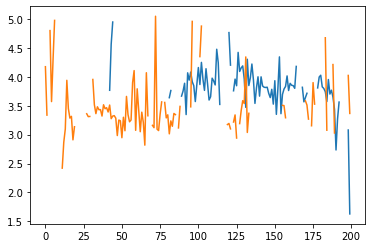

In [244]:
plt.plot([np.mean([dd for spec,dd in zip(loot[pov-663][0],loot[pov-663][2]) if spec == 'EC']) for ts,loot in traj_shell_dict.items()])
plt.plot([np.mean([dd for spec,dd in zip(loot[pov-663][0],loot[pov-663][2]) if spec == 'PF6']) for ts,loot in traj_shell_dict.items()])

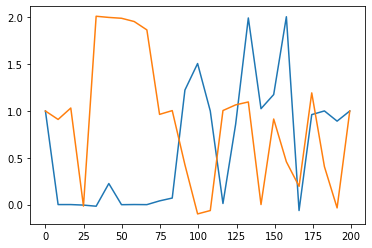

In [242]:
alpha = [counters[pov-663] for counters in np.array(species_count_dict['EC']).reshape(-1,114)]
beta = [counters[pov-663] for counters in np.array(species_count_dict['PF6']).reshape(-1,114)]
xrange = np.arange(0,200)

interploation_model_1 = interp1d(xrange, alpha, kind = "cubic")
interploation_model_2 = interp1d(xrange, beta, kind = "cubic")

xrange_ = np.linspace(xrange.min(), xrange.max(), 25)
alpha_ = interploation_model_1(xrange_)
beta_ = interploation_model_2(xrange_)

plt.plot(xrange_, alpha_)
plt.plot(xrange_, beta_)

## Single frame

For test frame == [0]

Population:
Cluster:0, pop:[8294, 8297, 8303, 8308, 8313, 8330, 8334, 8337, 8346, 8367, 8368, 8395, 8397] - (13)

Cluster:1, pop:[8290, 8291, 8292, 8293, 8295, 8296, 8298, 8299, 8301, 8302, 8305, 8306, 8309, 8311, 8312, 8315, 8317, 8318, 8319, 8321, 8322, 8324, 8326, 8327, 8332, 8333, 8335, 8336, 8338, 8340, 8341, 8342, 8343, 8344, 8345, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8357, 8358, 8359, 8361, 8362, 8364, 8365, 8366, 8369, 8370, 8371, 8372, 8375, 8376, 8377, 8378, 8380, 8381, 8382, 8383, 8385, 8387, 8389, 8390, 8394, 8396, 8398, 8399, 8400, 8401] - (73)

Cluster:2, pop:[8288, 8289, 8300, 8304, 8307, 8310, 8316, 8320, 8323, 8325, 8328, 8329, 8331, 8339, 8356, 8363, 8373, 8374, 8379, 8384, 8386, 8388, 8391, 8392, 8393] - (25)

Cluster:3, pop:[8314, 8347, 8360] - (3)
